In [1]:
%load_ext watermark
# sys, file and nav packages:
import datetime as dt
import json
import functools
import time
from os import listdir
from os.path import isfile, join
import typing

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import seaborn as sns

import IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display
from myst_nb import glue

import resources.landuse_config as luse

import time


# survey data:
dfx= pd.read_csv('resources/checked_sdata_eos_2020_21.csv')


dfBeaches = pd.read_csv("resources/beaches.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('location', inplace=True)

# set the index of to codes
dfCodes.set_index("code", inplace=True)

# code description map
code_d_map = dfCodes.description.copy()

# shorten the descriptions of two codes
code_d_map.loc["G38"] = "sheeting for protecting large cargo items"
code_d_map.loc["G73"] = "Foamed items & pieces (non packaging/insulation)"

# code material map
code_m_map = dfCodes.material

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_data = {'selector': 'td', 'props': 'padding: 6px;'}
table_css_styles = [even_rows, odd_rows, table_font, header_row]

pdtype = pd.core.frame.DataFrame
pstype = pd.core.series.Series

cmap = sns.diverging_palette(230, 20, as_cmap=True)

In [2]:
df = pd.read_csv('resources/surveys_iqaasl.csv')

# the name of the lake was changed in the revision

# the lakes of interest
# collection points would be a good
# label. This is how they are considered in the model
# these locations serve as the endpoint for many 
# small rivers
collection_points = [
    'zurichsee',
    'bielersee',
    'neuenburgersee',
    'walensee',
    'vierwaldstattersee',
    'brienzersee',
    'thunersee',
    'lac-leman',
    'lago-maggiore',
    'lago-di-lugano',
    'zugersee'
]

# the data-frame of survey results to be considered
features_of_interest = collection_points
df = df[df.feature.isin(features_of_interest)]

# test the survey results of an object of interest
# against a threshhold
code = "G95"
to_test = df[df.code == code].copy()
threshhold = to_test.pcs_m.median()

# map the location to the name of the lake
wn_map = df[["location", "feature"]].drop_duplicates("location").set_index("location")
wn_map = wn_map["feature"]


# The summary of the survey data
locations = df.location.unique()
samples = df.loc_date.unique()
lakes = df[df.w_t == "l"].drop_duplicates("loc_date").w_t.value_counts().values[0]
codes_identified = df[df.quantity > 0].code.unique()
codes_possible = df.code.unique()
total_id = df.quantity.sum()

data_summary = {
    "n locations": len(locations),
    "n samples": len(samples),
    "n lake samples": lakes,
    "n identified object types": len(codes_identified),
    "n possible object types": len(codes_possible),
    "total number of objects": total_id
}

pd.DataFrame(index = data_summary.keys(), data=data_summary.values()).style.set_table_styles(table_css_styles)

,0
n locations,93
n samples,331
n lake samples,331
n identified object types,205
n possible object types,230
total number of objects,52269


## The map data

The proceeding is the land-use categories and the relevant sub-categories. With the exception of _Land Cover_ the total of each category was considered for each hex. The covariance of each sub-category is given in the annex.

### The base: Land cover

This is how the earth is covered, independent of its use. The following categories are the base land-cover categories:

1. Orchard
2. Vineyards
3. Settlement
4. City center
5. Forest
6. Undefined
7. Wetlands

The area of each sub-category of land-cover within a 3000 m hex is totaled and the correlation is considered independently. The categories that follow are superimposed on to these surfaces.

In [3]:
my_path=  "resources/hex-3000m-cleaned"

columns = [
    "river_bass",
    "location", 
    "city",
    "feature"
]

column_rename = {"undefined":"Undefined"}
area_of_a_hex = 5845672
id_vals = ["location", "OBJVAL"]
agg_val = "surface"

data_map_name = "lake-locations-landcover"

lc_groups = [
    'Siedl',
    'Undefined',
    'Wald'
]

lc_presence = [
    'Obstanlage',
    'Reben',
    'Stadtzentr',
    'Sumpf',
    'Fels'
]

groups_and_presence = [*lc_groups, *lc_presence]
       
merge_column = gby_column = "location"
merge_method = 'outer'
merge_validate = "many_to_one"
quantiles =   [0,.1, .25, .5, .75, .9, 1]
        
# label the region of interest
# this creates a hierarcal group of the locations
# that are within a region. The most common would be lake
regional_label = "lake"
label_map = wn_map

# collect the data
data_map = luse.collect_feature_data(path_to_data=my_path)
land_cover_data = data_map[data_map_name]
land_cover_data.rename(columns=column_rename, inplace=True)

# limit the data to the parameters of interest


land_use_kwargs = {
    "data_map":land_cover_data,
    "locations":locations,
    "region":None,
    "columns":columns,
    "id_vals": id_vals,
    "dim_oi": area_of_a_hex,
    "to_aggregate":agg_val,
    "land_use_groups":lc_groups,
}

test_kwargs = {
    "df":to_test,
    "threshhold":threshhold,
    "merge_column":merge_column,
    "merge_method":merge_method,
    "merge_validate":merge_validate,
    "groups":lc_groups,
    "presence":lc_presence,
    "quantiles":quantiles
}

inf_operation = {"k":"sum", "n":"sum"}

In [4]:
kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': None,
    'assign_undefined': True,
    'length': False,
    'cover': True,
    'inf_operation': inf_operation,
    'regional_label': regional_label,
    'label_map': label_map,
    'total': False
}


nx = luse.LanduseConfiguration(**kwargs)
nx.groups_and_presence()
nx.inference_groups()
nxf = nx.grouped_data
nx_conf = nx.labeled_groups

In [5]:
# add the data from another land use layer
# the results will be added to the landcover data frame
label = "strasse"
data_map_name = 'lake-locations-strasse'
id_vals = ["location", "OBJEKTART"]
agg_val = "length"

# identify the columns of interest
st_groups = [
    '10m Strasse',
    '1m Weg',
    '1m Wegfragment',
    '2m Weg',
    '2m Wegfragment',
    '3m Strasse',
    '4m Strasse',
    '6m Strasse',
    '8m Strasse',
    'Ausfahrt',
    'Autobahn',
    'Autostrasse',
    'Dienstzufahrt',
    'Einfahrt',
    'Faehre',
    'Markierte Spur',
    'Platz',
    'Raststaette', 'Verbindung', 'Zufahrt'
]

st_presence = []

groups_and_presence = [*st_groups, *st_presence]

# collect the data
street_lengths_data = data_map[data_map_name]

# update the key word arguments for the land use data
land_use_update = dict(data_map=street_lengths_data, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=st_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=st_groups, presence=None)
test_kwargs.update(test_update)

kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': 'strasse',
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': None,
    'total': True
}

strasse = luse.LanduseConfiguration(**kwargs)

strasse.groups_and_presence()
strasse.inference_groups()
sxf = strasse.grouped_data
sx_conf = strasse.labeled_groups
strasse_config = strasse.configuration_keys

In [6]:
# add the data from another land use layer
# the results will be added to the landcover data frame
# column_rename = {"undefined":"Undefined"}
data_map_name = 'lake-locations-freizeitareal'
id_vals = ["location", "OBJEKTART"]
agg_val = "surface"
columns = [
    "river_bass",
    "location",
    "city",
    "feature"
]

recreation_data = data_map[data_map_name]
# identify the columns of interest
rec_groups = recreation_data.OBJEKTART.unique()
rec_presence = []

groups_and_presence = [*rec_groups, *rec_presence]
# update the key word arguments for the land use data
land_use_update = dict(data_map=recreation_data, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=rec_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=rec_groups, presence=None)
test_kwargs.update(test_update)

kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': 'recreation',
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': None,
    'total': True
}

recreation = luse.LanduseConfiguration(**kwargs)
recreation.groups_and_presence()
recreation.inference_groups()
rec_config = recreation.configuration_keys

In [7]:
# add the data from another land use layer
# the results will be added to the landcover data frame
data_map_name = 'lake-locations-nutuzungsareal'
id_vals = ["location", "OBJEKTART"]
agg_val = "surface"

columns = [
    "river_bass",
    "location", 
    "city",
    "feature"
]


infrastructure_data = data_map[data_map_name]

# identify the columns of interest
inf_groups = infrastructure_data.OBJEKTART.unique()
inf_presence = []

groups_and_presence = [*inf_groups, *inf_presence]
# update the key word arguments for the land use data
land_use_update = dict(data_map=infrastructure_data, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=inf_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=inf_groups, presence=None)
test_kwargs.update(test_update)

kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': 'infrastructure',
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': None,
    'total': True
}

infrastructure = luse.LanduseConfiguration(**kwargs)
infrastructure.groups_and_presence()
infrastructure.inference_groups()
inra_config = infrastructure.configuration_keys

In [8]:
data_map_name = 'resources/hex-3000m-cleaned/river-intersections-2k.csv'
intersections = pd.read_csv(data_map_name)
intersections = intersections.drop_duplicates(["location", "name"])
dints = intersections.groupby("location").distance.sum()
nints = intersections.groupby("location").distance.nunique()
ints_d = pd.DataFrame(dints/nints).reset_index()
ints_d = pd.melt(ints_d, id_vars="location", value_vars="distance").fillna(0)

river_length = pd.read_csv('resources/hex-3000m-cleaned/river-length-2k.csv')
river_length = river_length.drop_duplicates(["location", "name"])
nlen = river_length.groupby("location").length.nunique()
llen = river_length.groupby("location").length.sum()
lengths_d = pd.DataFrame(llen/nlen).reset_index()
len_d = pd.melt(lengths_d, id_vars="location", value_vars="length").fillna(0)

In [9]:
dfx = pd.read_csv('resources/checked_sdata_eos_2020_21.csv')
locations = dfx.location.unique()

In [10]:
missl = [x for x in intersections.location.unique() if x not in locations]
missl

[]

In [ ]:
intersections

In [11]:
intersections[intersections.location == 'boiron']

,river_bass,location,city,feature,name,distance
2874,rhone,boiron,Tolochenaz,lac-leman,La Morges,1705.243588
2875,rhone,boiron,Tolochenaz,lac-leman,Le Boiron de Nyon,48.213544


In [12]:
f = pd.read_csv("resources/hex-3000m-cleaned/river-length-2k.csv")
missing = [x for x in f.location.unique() if x not in locations]
[x for x in missl if x not in missing]

[]

In [13]:
river_length[river_length.isnull()]

,river_bass,location,city,feature,name,length,distance
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
688,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
id_vals = ["location", "variable"]
agg_val = "value"
inf_groups = ["distance"]
inf_presence = []

groups_and_presence = [*inf_groups, *inf_presence]



# update the key word arguments for the land use data
land_use_update = dict(data_map=ints_d, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=inf_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=inf_groups, presence=None)
test_kwargs.update(test_update)



kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': "r-distance",
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': label_map,
    'total': True
}

distance = luse.LanduseConfiguration(**kwargs)
distance.groups_and_presence()
distance.inference_groups()
dist_conf = distance.configuration_keys

In [15]:

id_vals = ["location", "variable"]
agg_val = "value"
inf_groups = ["length"]
inf_presence = []

groups_and_presence = [*inf_groups, *inf_presence]



# update the key word arguments for the land use data
land_use_update = dict(data_map=len_d, id_vals=id_vals, to_aggregate=agg_val, land_use_groups=inf_groups)
land_use_kwargs.update(land_use_update)

# update the key word arguments for the test data
test_update = dict(groups=inf_groups, presence=None)
test_kwargs.update(test_update)



kwargs = {
    'land_use_kwargs': land_use_kwargs,
    'test_kwargs': test_kwargs,
    'label': "r-length",
    'assign_undefined': False,
    'length': True,
    'cover': False,
    'inf_operation': inf_operation,
    'regional_label': None,
    'label_map': label_map,
    'total': True
}

intersections = luse.LanduseConfiguration(**kwargs)
intersections.groups_and_presence()
intersections.inference_groups()
int_conf = intersections.configuration_keys

In [16]:
# add results for land use to land cover 
# drop the conf column
fgl = nx_conf.drop("conf", axis=1)

fgl['infrastructure'] = fgl.location.apply(lambda x: inra_config.loc[x][0][0])
fgl['strasse'] = fgl.location.apply(lambda x: strasse_config.loc[x][0][0])
fgl['recreation'] = fgl.location.apply(lambda x: rec_config.loc[x][0][0])
fgl['r-length'] = fgl.location.apply(lambda x: int_conf.loc[x][0][0])
fgl['r-distance'] = fgl.location.apply(lambda x: dist_conf.loc[x][0][0])
fgl = fgl.fillna(0)
# define the confiugration columns
conf_columns = [*lc_groups, *lc_presence, 'infrastructure', 'strasse', 'recreation', 'r-length', 'r-distance']
fgl['configuration'] = list(zip(*[fgl[x] for x in conf_columns]))
fgl_conf_keys = fgl[["location", "configuration"]].set_index("location")

# update the probability tables
fgl_ptables =nx.p_tables
fgl_ptables.update(infrastructure.p_tables)
fgl_ptables.update(recreation.p_tables)
fgl_ptables.update(strasse.p_tables)
fgl_ptables.update(intersections.p_tables)
fgl_ptables.update(distance.p_tables)

In [17]:
inference_kwargs = {
    'location': " ",
    'lake': "",
    'conf_label': 'configuration',
    'fgl_conf_keys':fgl_conf_keys,
    'conf_columns': conf_columns,
    'p_tables': fgl_ptables,
    'tested':nx.grouped_data,
    'prior':None,
    'drop_vals': None
}



bsee_l = nx.grouped_data[nx.grouped_data.lake.isin(features_of_interest)].location.unique()
res = []
for alocation in bsee_l:
    inference_kwargs.update({"location":alocation})
    p=luse.inference_for_one_location(**inference_kwargs)
    res.append({'location':alocation, 'p':p})

lct = nx.test_results.test_and_merge()
sct = strasse.test_results.test_and_merge(cover=False)
rct = recreation.test_results.test_and_merge(cover=False)
ict = infrastructure.test_results.test_and_merge(cover=False)
dist_ct = distance.test_results.test_and_merge(cover=False)
ints_ct = intersections.test_results.test_and_merge(cover=False)

dfs = [lct, sct, rct, ict, dist_ct, ints_ct]

print(code, threshhold)
p_of = pd.DataFrame(res)
p_of

G95 0.02


,location,p
0,aabach,0.608766
1,anarchy-beach,0.619628
2,ascona-traghetto-spiaggia,0.606723
3,augustmutzenbergstrandweg,0.292101
4,baby-plage-geneva,0.419333
...,...,...
88,zuerichsee_waedenswil_colomboc_1,0.295100
89,zugerseecholler_cham_blarerm,0.285809
90,zurcher-strand,0.459357
91,zurichsee_kusnachterhorn_thirkell-whitej,0.291816


In [18]:
p_of["p"].describe()

count    93.000000
mean      0.432058
std       0.216879
min       0.045455
25%       0.266257
50%       0.376590
75%       0.634689
max       0.922573
Name: p, dtype: float64

## Logistic regression

### infrastructure

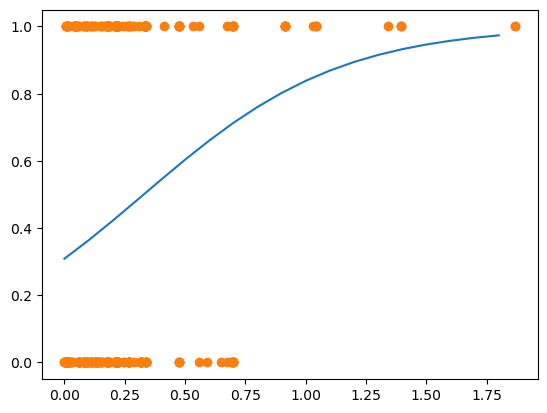

In [19]:
import statsmodels.formula.api as smf
from scipy.special import expit
to_test["failed"] = (df.pcs_m > threshhold).astype('int')
log_of = to_test[["location", "failed"]].copy()
log_of["infrastructure"] = log_of.location.apply(lambda x: ict.loc[ict.location == x, "infrastructure"].values[0])
log_of["infrastructure"] = log_of.infrastructure/1000000

obj_min, obj_max = log_of.infrastructure.min(), log_of.infrastructure.max()

formula = 'failed ~ infrastructure'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['infrastructure']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

plt.plot(xs, ps_x)
plt.plot(log_of["infrastructure"], log_of["failed"], 'o')

### city

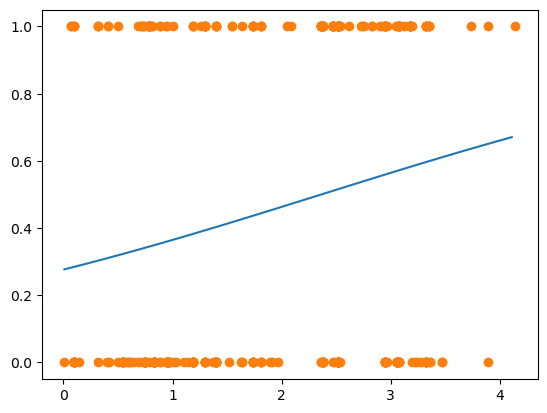

In [20]:
log_of = to_test[["location", "failed"]].copy()
log_of["Siedl"] = log_of.location.apply(lambda x: lct.loc[lct.location == x, "Siedl"].values[0])
log_of["Siedl"] = log_of.Siedl/1000000

obj_min, obj_max = log_of.Siedl.min(), log_of.Siedl.max()

formula = 'failed ~ Siedl'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Siedl']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

plt.plot(xs, ps_x)
plt.plot(log_of["Siedl"], log_of["failed"], 'o')

### forest

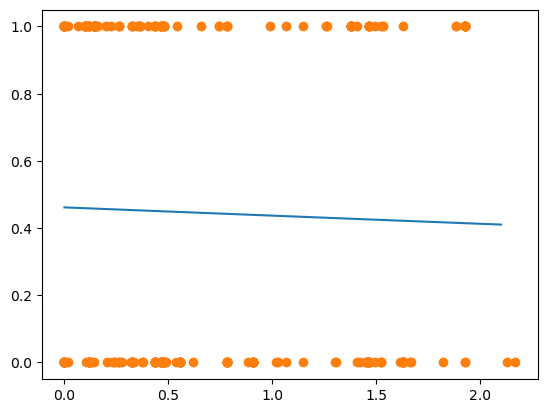

In [21]:
log_of = to_test[["location", "failed"]].copy()
log_of["Wald"] = log_of.location.apply(lambda x: lct.loc[lct.location == x, "Wald"].values[0])
log_of["Wald"] = log_of.Wald/1000000

obj_min, obj_max = log_of.Wald.min(), log_of.Wald.max()

formula = 'failed ~ Wald'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Wald']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

plt.plot(xs, ps_x)
plt.plot(log_of["Wald"], log_of["failed"], 'o')

### undefined

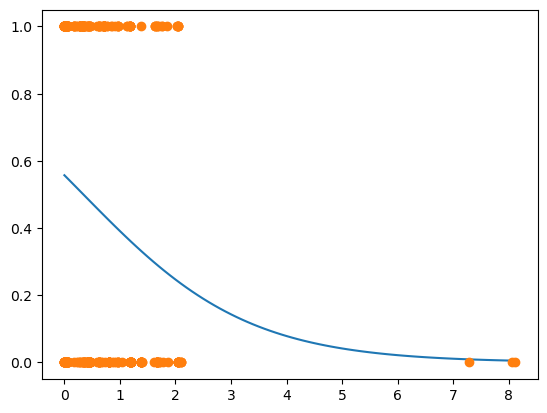

In [22]:
log_of = to_test[["location", "failed"]].copy()
log_of["Undefined"] = log_of.location.apply(lambda x: lct.loc[lct.location == x, "Undefined"].values[0])
log_of["Undefined"] = log_of.Undefined/1000000

obj_min, obj_max = log_of.Undefined.min(), log_of.Undefined.max()

formula = 'failed ~ Undefined'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['Undefined']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

plt.plot(xs, ps_x)
plt.plot(log_of["Undefined"], log_of["failed"], 'o')

### recreation

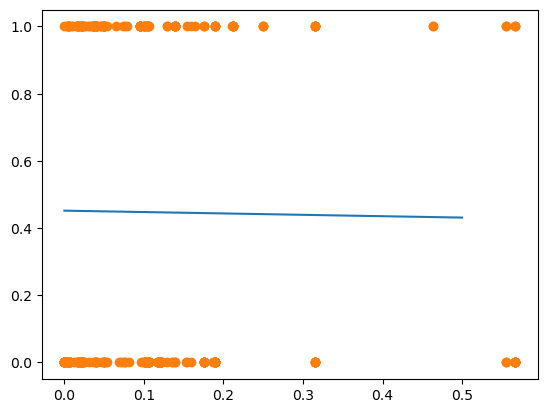

In [23]:
log_of = to_test[["location", "failed"]].copy()
log_of["recreation"] = log_of.location.apply(lambda x: rct.loc[rct.location == x, "recreation"].values[0])
log_of["recreation"] = log_of.recreation/1000000

obj_min, obj_max = log_of.recreation.min(), log_of.recreation.max()

formula = 'failed ~ recreation'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['recreation']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

plt.plot(xs, ps_x)
plt.plot(log_of["recreation"], log_of["failed"], 'o')

### distance to

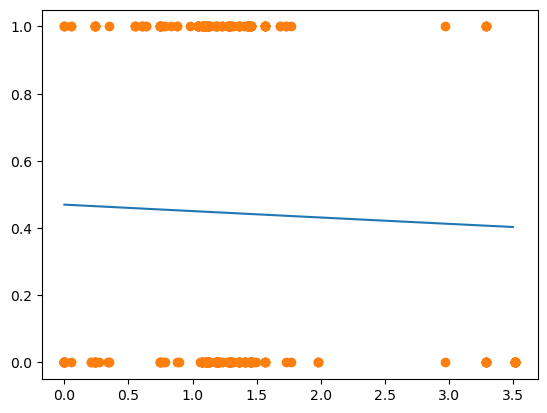

In [24]:
log_of = to_test[["location", "failed"]].copy()

log_of["r-distance"] = log_of.location.apply(lambda x: dist_ct.loc[dist_ct.location == x, "r-distance"].values[0])
log_of["r-distance"] = log_of["r-distance"]/1000
log_of.rename(columns={'r-distance':'r_distance'}, inplace=True)

obj_min, obj_max = log_of["r_distance"].min(), log_of["r_distance"].max()

formula = 'failed ~ r_distance'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['r_distance']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

plt.plot(xs, ps_x)
plt.plot(log_of["r_distance"], log_of["failed"], 'o')

### river length

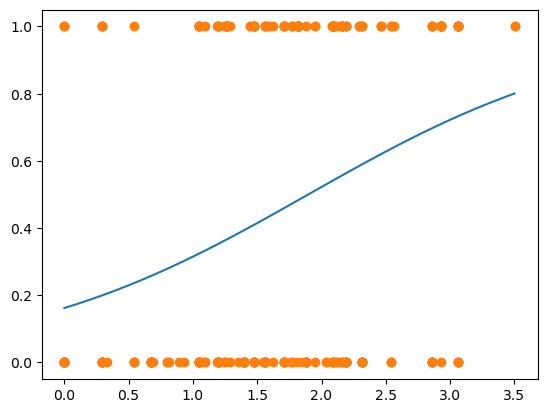

In [25]:
log_of = to_test[["location", "failed"]].copy()

log_of["r-length"] = log_of.location.apply(lambda x: ints_ct.loc[ints_ct.location == x, "r-length"].values[0])
log_of["r-length"] = log_of["r-length"]/1000
log_of.rename(columns={'r-length':'r_length'}, inplace=True)

obj_min, obj_max = log_of["r_length"].min(), log_of["r_length"].max()

formula = 'failed ~ r_length'
results = smf.logit(formula, data=log_of).fit(disp=False)
inter = results.params['Intercept']
slope = results.params['r_length']
xs = np.arange(obj_min, obj_max, step=.1)

log_odds = inter + slope * xs
odds = np.exp(log_odds)

ps_x = expit(inter + slope * xs)

plt.plot(xs, ps_x)
plt.plot(log_of["r_length"], log_of["failed"], 'o')

In [26]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)



This script updated 03/05/2023 in Biel, CH

> ❤️ what you do everyday

*analyst at hammerdirt*


In [27]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/landuse.git

Git branch: probability

json       : 2.0.9
statsmodels: 0.13.5
PIL        : 9.5.0
pandas     : 2.0.0
numpy      : 1.24.2
IPython    : 8.12.0
seaborn    : 0.12.2
matplotlib : 3.7.1
scipy      : 1.10.1

